# Setup
Thibault de Surrel and Alexandre Pradeilles


**Imports**

In [ ]:
!pip install contextily
!pip install geopandas
!pip install ruptures
!pip install pygsp
!pip install loadmydata

In [ ]:
import datetime as dt
from math import log
from math import asin, cos, radians, sin, sqrt
import IPython
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import contextily as cx
import geopandas
import pandas as pd
import numpy as np
import ruptures as rpt
from pygsp import graphs
from ruptures.base import BaseCost
from scipy.signal import chirp, stft, sweep_poly
from scipy.spatial.distance import pdist, squareform
import scipy

rng = np.random.default_rng()

**Utility functions**

In [ ]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}
FS = 22_050  # Hz
sigma = 2


def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

# Question 1


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [ ]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

9 2 9 A D A 1 8 D


(0.0, 4000.0)

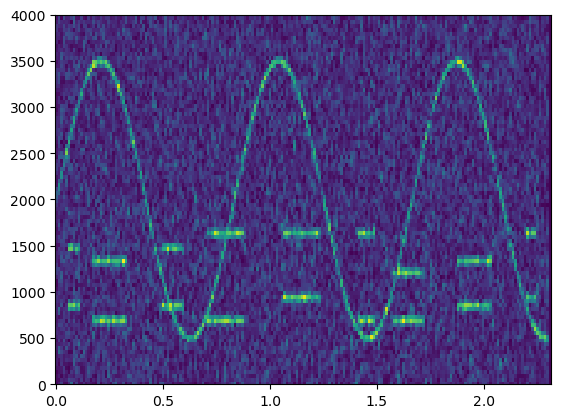

In [ ]:
f, t, Sxx = stft(signal, FS, nperseg=512)
plt.pcolormesh(t, f, np.abs(Sxx))
plt.ylim((0, 4000))

In [ ]:
# This function extract the closest frequency from freq it is possible to find in the output of the stft function
def get_closest_id(freq, f_list):
    i = 0
    while i < len(f_list) and freq > f_list[i]:
        i += 1
    if i == 0:
        return i
    else:
        if freq - f_list[i-1] < f_list[i] - freq:
            return i-1
        else:
            return i
        
get_closest_id(697, f)


16

In [ ]:
ff = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
idexes = list()
for freq in ff:
    idexes.append(get_closest_id(freq, f))

dictio_symboles = {(idexes[0], idexes[4]): "1", (idexes[0], idexes[5]): "2", (idexes[0], idexes[6]): "3", (idexes[0], idexes[7]): "A", (idexes[1], idexes[4]): "4", (idexes[1], idexes[5]): "5",
                   (idexes[1], idexes[6]): "6", (idexes[1], idexes[7]): "B", (idexes[2], idexes[4]): "7", (idexes[2], idexes[5]): "8", (idexes[2], idexes[6]): "9",
                   (idexes[2], idexes[7]): "C", (idexes[3], idexes[4]): "*", (idexes[3], idexes[5]): "0", (idexes[3], idexes[6]): "#", (idexes[3], idexes[7]): "D"}

In [ ]:
class MultivariateNormalCost(BaseCost):

    """Custom cost for piecewise Gaussian signals."""

    # The 2 following attributes must be specified for compatibility.
    model = ""
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub_signal = self.signal[start:end]
        cov_mat = np.cov(sub_signal.T)
        _, cost_val = np.linalg.slogdet(cov_mat)
        cost_val *= (end-start)
        return cost_val

In [ ]:
def decode_signal(signal, n_bkps=20):
    # Apply Fourier Transform
    f, t, Sxx = stft(signal, FS, nperseg=512)

    # Hyperparameter n bkps
    n_bkps = Sxx.shape[1] // 6
    
    # Rupture detection algorithm
    algo = rpt.Dynp(custom_cost =  MultivariateNormalCost()).fit(np.abs(Sxx[:50]).T) 
    bkps = algo.predict(n_bkps=n_bkps)
    bkps = [0] + bkps + [Sxx.shape[1]]

    # Plot ruptures
    plt.pcolormesh(t, f[:50], np.abs(Sxx[:50, :]))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    for b in bkps[:-1]:
        plt.axvline(t[b-1])
    plt.show()

    ind = []

    # Find the two main frequencies of each part and assign the corresponding symbol if the mean absolute value is over 0.25
    for i in range(len(bkps)-1):
        elem = np.abs(Sxx[:100, bkps[i]:bkps[i+1]+1])
        if elem.shape[1] > 0:
            maxi_freq = sorted(list(zip(np.mean(elem, axis=1)[idexes], idexes)))[-2:]
            if maxi_freq[0][0] > 0.25 and maxi_freq[1][0] > 0.25:
                ind.append(tuple(sorted([maxi_freq[0][1], maxi_freq[1][1]])))
            else:
                ind.append((-1, -1))
        else:
            ind.append((-1, -1))

    # Regroup the part of the signal corresponding to the same symbol
    sym = list()
    for couple in ind:
        if couple in dictio_symboles:
            l = dictio_symboles[couple]
            if len(sym) > 0 and sym[-1] != l:
                sym.append(l)
        else:
            sym.append('')
    # Final output
    return ''.join(sym)

929ADA18D


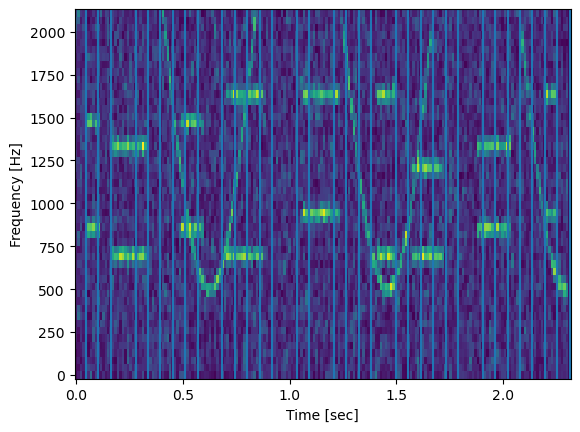

929ADA18D


In [ ]:
# signal, symbols = generate_signal()
print("".join(symbols))
print(decode_signal(signal, n_bkps=40))

# Question 2

In [ ]:
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")

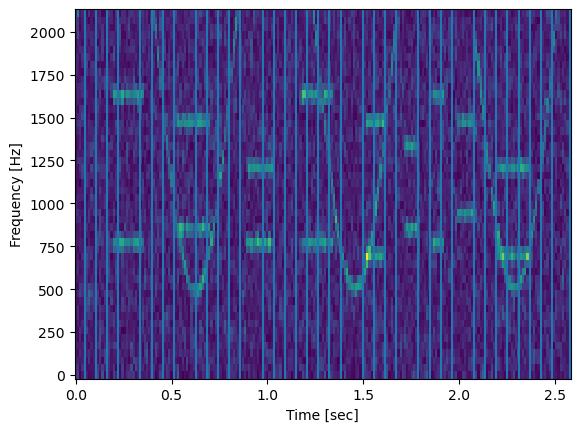

'B94B38B#1'

In [ ]:
decode_signal(sound_1)

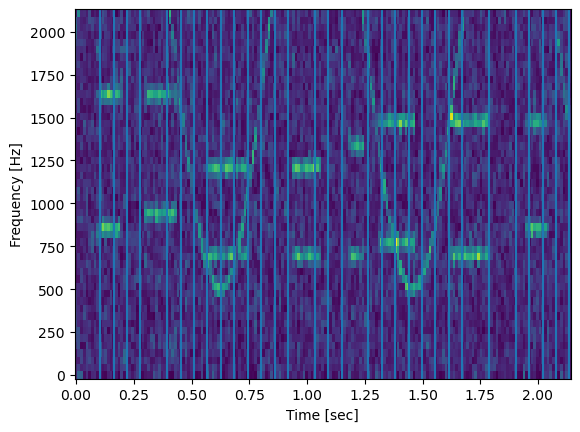

'CD112639'

In [ ]:
decode_signal(sound_2)

# Question 3

We start by defining two functions to compute the kernel functions $\hat{g}_m$.

In [ ]:
def G(lamb, R, a):
    return 0.5*(1 + np.cos(2*np.pi*(lamb /(a*R) + 0.5)))*((lamb < 0) & (lamb>= -R*a)).astype(int)

In [ ]:
def gm(lamb, m, R,lambdn = 12):
    a = lambdn /(10-R)
    return G(lamb - a*m, R, a)

We can then plot the kernel functions for $R = 1$, $R = 3$ and $R = 5$.

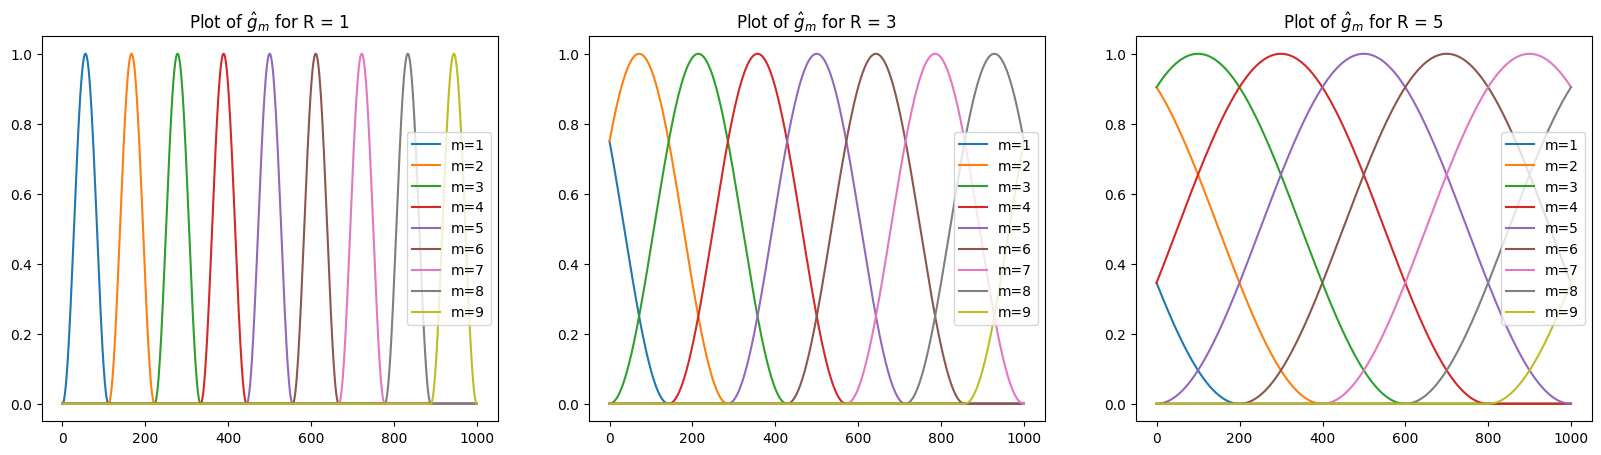

In [ ]:
lamb = np.linspace(0, 12, 1000)
R_list = [1,3,5]
plt.figure(figsize = (20,5))
for plot in range(3):
  plt.subplot(1,3,plot+1)
  for i in range(1, 10):
      plt.plot(gm(lamb, i, R_list[plot]), label=f"m={i}")

  plt.title("Plot of $\\hat{g}_m$ for R = " + str(R_list[plot]))
  plt.legend()

# Question 4

We start by loading and preprocessing the data. In particular, we remove all stations with missing values in the temperature.

In [ ]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
data_df, stations_df, description = load_molene_meteo_dataset()

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

In [ ]:
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
DROPLIST = temperature_df.columns[temperature_df.isna().sum(axis=0) > 0].to_list()
print("The station with NaN in their data are : ", DROPLIST)

CRS = "EPSG:4326"
keep_cond = stations_df.Nom.isin(DROPLIST)
dropped_names = stations_df[keep_cond].Nom
stations_df = stations_df[~keep_cond]
keep_cond = data_df.station_name.isin(DROPLIST)
data_df = data_df[~keep_cond].reset_index().drop("index", axis="columns")

# convert temperature from Kelvin to Celsius
#data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

The station with NaN in their data are :  ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


Then, we can compute distance matrix.

In [ ]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

We can now compute the exponential smoothing. We find the the minimum threshold so that the network is connected and the average degree is at least 3.

In [ ]:
threshold_list = np.arange(0,1,0.01)
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold_min = threshold_list[0]
for th in threshold_list:
    adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, th)
    )
    G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
    if G_gaussian.is_connected(recompute=True) and (np.mean(G_gaussian.d) >= 3):
        if th > threshold_min:
            threshold_min = th
            
#Once we found the threshold min, we compute the corresponding graph
adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, threshold_min)
    )
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
print(
    f"The graph is {'not ' if not G_gaussian.is_connected(recompute=True) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges and the average degree of G_gaussian is {np.mean(G_gaussian.d)}. The corresponding threshold is {threshold_min}"
  )

The graph is connected, with 37 nodes, 75 edges and the average degree of G_gaussian is 4.054054054054054. The corresponding threshold is 0.8300000000000001


We can then plot the corresponding graph.

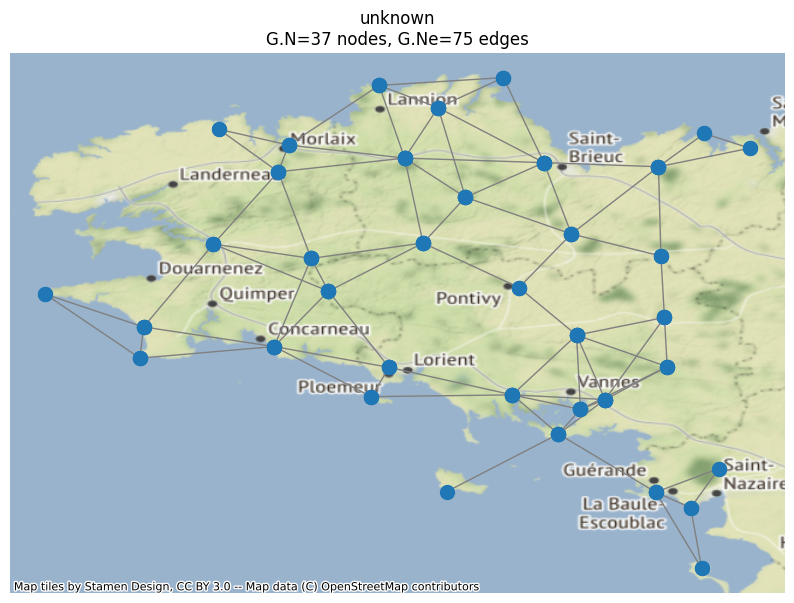

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)

In [ ]:
temperature_df_no_nan = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
temperature_df_no_nan.head()

station_name,AURAY,BELLE ILE-LE TALUT,BIGNAN,DINARD,GUERANDE,GUISCRIFF SA,ILE DE GROIX,ILE-DE-BREHAT,KERPERT,LORIENT-LANN BIHOUE,...,SAINT-CAST-LE-G,SAINT-JOACHIM_SAE,SARZEAU SA,SIBIRIL S A,SPEZET,ST BRIEUC,ST-SEGAL S A,THEIX,TREGUNC,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,10.3,11.3,7.1,6.8,10.4,8.3,9.0,7.0,5.9,9.0,...,6.1,9.3,9.8,7.4,8.3,7.5,9.0,9.3,10.8,9.7
2014-01-01 01:00:00,10.4,10.3,7.6,6.5,10.6,7.8,10.0,7.0,5.9,10.0,...,6.3,9.3,9.9,8.2,8.6,7.0,9.5,9.1,10.9,9.9
2014-01-01 02:00:00,10.0,11.2,7.7,6.5,10.2,8.4,9.5,7.8,6.4,8.9,...,6.4,9.5,9.2,8.5,8.6,7.5,9.4,9.4,10.6,9.6
2014-01-01 03:00:00,10.4,11.4,7.9,7.1,10.6,8.4,10.4,8.3,6.7,10.1,...,7.0,9.0,10.1,8.5,8.9,7.2,9.9,8.9,10.8,9.8
2014-01-01 04:00:00,10.8,11.4,8.8,7.6,10.6,8.9,10.8,8.9,6.9,10.4,...,7.7,9.9,10.5,9.1,9.4,7.6,10.0,9.6,11.0,10.2


Finally, we compute the corresponding signal and find the time when the signal is the least smooth and the smoothest.

In [ ]:
signals = temperature_df_no_nan.to_numpy()
laplacian_matrix = G_gaussian.L.todense()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df_no_nan.index
)

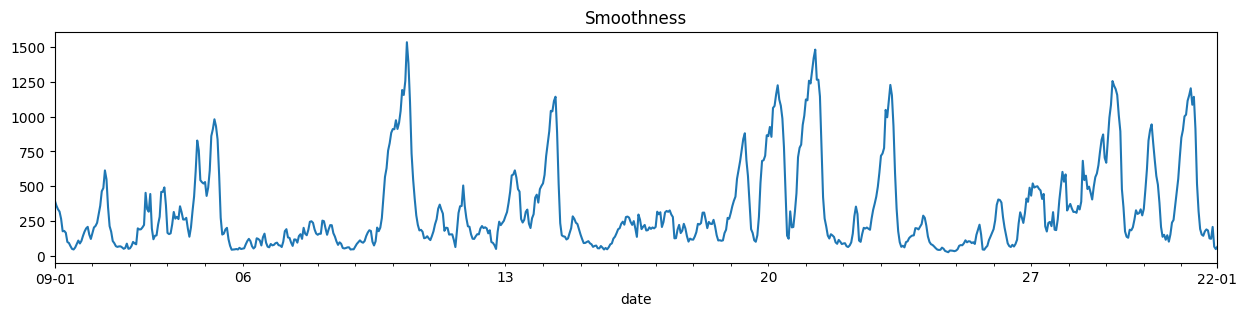

In [ ]:
fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

In [ ]:
argmin_index = np.argmin(smoothness_df)
argmax_index = np.argmax(smoothness_df)

print(f"Time where the signal is the smoothest: {temperature_df_no_nan.index[argmin_index]}")
print(f"Time where the signal is the least smooth: {temperature_df_no_nan.index[argmax_index]}")

Time where the signal is the smoothest: 2014-01-24 19:00:00
Time where the signal is the least smooth: 2014-01-10 09:00:00


# Question 5

We implement a function that computes the graph wavelet transform. Then, we plot the classified nodes into low/medium/high frequency for the 3 signal asked.

In [ ]:
import numpy as np
from scipy.sparse import spdiags
from statistics import mode

def graph_wavelet_transform(L, f, R):
    n = L.shape[0] # number of nodes
    M = 9 # number of scales
    a = L[-1,-1] / (M+1-R) # scaling parameter

    # Compute eigenvectors of Laplacian matrix
    eigenvals, U = np.linalg.eigh(L)
    eigenvals = eigenvals.astype(np.float64)

    # Compute Fourier transform of f
    #f_hat = np.fft.fft(f)
    f_hat = U.T @ f  
    
    # Compute wavelet coefficients
    wavelet_coeffs = np.zeros((M, n))
    for m in range(1, M+1):
        g_hat = gm(eigenvals, m, R)
        wavelet_coeffs[m-1,:] = np.array(np.real(g_hat * np.array(f_hat) @ U.T))[0]

    return wavelet_coeffs

In [ ]:
def get_labels(laplacian_matrix,temperature_df_no_nan,ind):
    W = graph_wavelet_transform(laplacian_matrix, temperature_df_no_nan.iloc[ind].values, 3)
    nb_nodes = W.shape[1]
    signal = np.zeros(nb_nodes)
    for v in range(nb_nodes):
        val = [sum(np.abs(W[:3,v])**2),sum(np.abs(W[3:6,v])**2),sum(np.abs(W[6:,v])**2)]
        signal[v] = np.argmax(val)
    return signal

For the smoothest signal

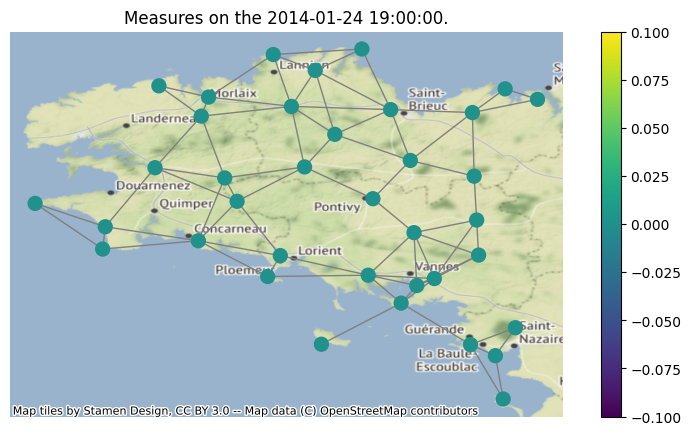

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(get_labels(laplacian_matrix,temperature_df_no_nan,argmin_index), ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmin_index]}."
)
plt.savefig("smoothest_2.pdf")

For the least smooth signal

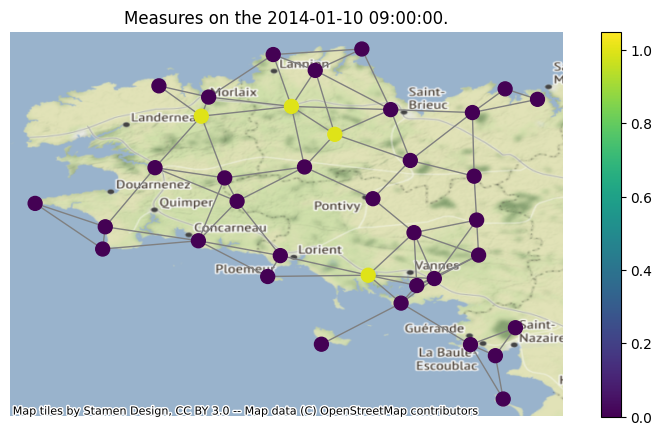

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(get_labels(laplacian_matrix,temperature_df_no_nan,argmax_index), ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmax_index]}."
)
plt.savefig("least_smooth_2.pdf")

For the first available timestamp

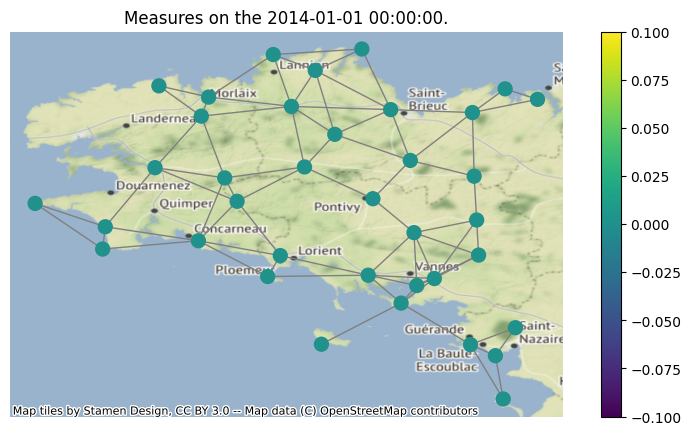

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(get_labels(laplacian_matrix,temperature_df_no_nan,0), ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[0]}."
)
plt.savefig("first_2.pdf")

# Question 6

Now, we can plot the average temperature. For each timestamp, we use a color code corresponding to the the majority class present in the graph. We can see that all nodes are classifed as low.

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

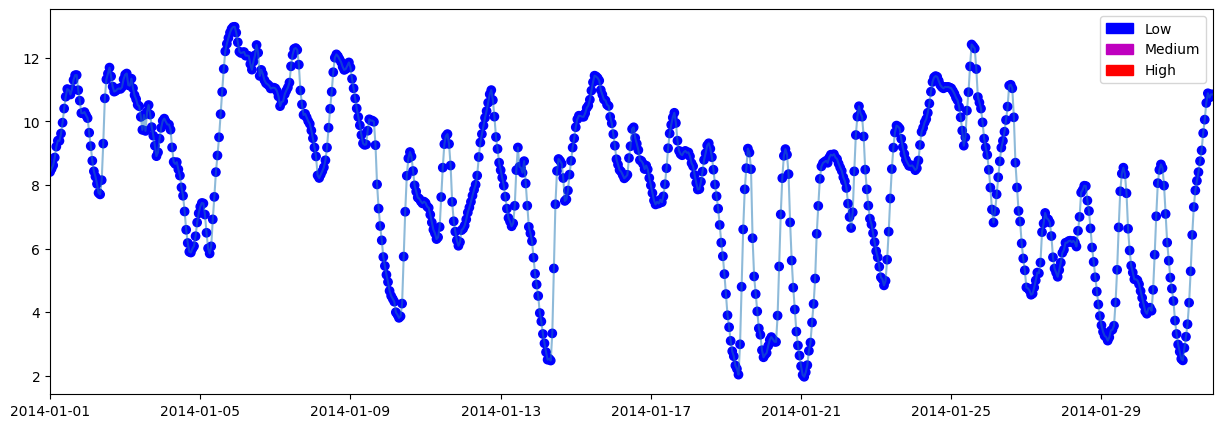

In [ ]:
import matplotlib.patches as mpatches

y = np.mean(temperature_df_no_nan.values, axis=1)
x = temperature_df_no_nan.index
#class_array = [mode(np.argmax(graph_wavelet_transform(laplacian_matrix, temperature_df_no_nan.iloc[ind].values, 3), axis=0)) for ind in range(len(x))]
class_array = [mode(get_labels(laplacian_matrix,temperature_df_no_nan,i)) for i in range(len(x))]

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)
low_patch = mpatches.Patch(color='b', label='Low')
medium_patch = mpatches.Patch(color='m', label='Medium')
high_patch = mpatches.Patch(color='r', label='High')
plt.legend(handles=[low_patch,medium_patch,high_patch])
# do not forget to explain the colours in the report
plt.savefig("average_temp.pdf")

# Question 7

In [ ]:
# Compute L(G)
L_G = G_gaussian.L
In = scipy.sparse.eye(L_G.shape[0])

# Compute L(G')
L_G_prime = get_line_graph(n_nodes=temperature_df_no_nan.index.size).L
Im = scipy.sparse.eye(L_G_prime.shape[0])

H = scipy.sparse.kron(L_G,Im) + scipy.sparse.kron(In,L_G_prime)

We cannot use the function `get_labels` implemented previously because the matrix H is too big. But we have an easy way to compute its eigenvalues and eigenvectors so we can reimplemented it differently.

In [ ]:
def g_m(lambd, R, m, lambdn = 12, M = 9): 
    a = lambdn / (M + 1 - R)
    return g_u(lambd - a*m, R, a, lambdn = 12, M = 9)

def g_u(lambd, R, a, lambdn = 12, M = 9):
    if (lambd < 0) and (lambd >= -R*a):
        return  0.5 * (1 + np.cos(2*np.pi*(lambd/(a*R) + 0.5)))
    else:
        return 0 

In [ ]:
eigenval_L_G, eigenvec_L_G = np.linalg.eig(L_G.todense())
eigenval_L_G_prime, eigenvec_L_G_prime = np.linalg.eig(L_G_prime.todense())

# We compute the eigenvalues of H
eigenvals_H = []
for i in range(len(eigenval_L_G)):
    for j in range(len(eigenval_L_G_prime)):
        eigenvals_H.append(eigenval_L_G[i] + eigenval_L_G_prime[j])
eigenvals_H = np.array(eigenvals_H)   


# We compute the eigenvectors of H
print("Computation of the eigenvectors of H")
eigenvects_H = []
for i in tqdm(range(len(eigenval_L_G))):
    for j in range(len(eigenval_L_G_prime)):
        eigenvects_H.append(np.array(np.kron(eigenvec_L_G[0],eigenvec_L_G_prime[0]))[0])
eigenvects_H = np.array(eigenvects_H)

# Sort eigenvalues and eigenvectors 
idx = eigenvals_H.argsort()
eigenvals_H = eigenvals_H[idx]
eigenvects_H = eigenvects_H[idx,:]
print("Computation of the eigenvectors of H done.")

n = L_G.shape[0]*L_G_prime.shape[0] # number of nodes
M = 9 # number of scales
R = 3
# Compute the Graph Fourrier Transform (GFT) of the graph signal "f"
f = np.ravel(temperature_df_no_nan.to_numpy(), order='F')
f_hat = eigenvects_H @ f 

print("Computing the wavelet transform of the temperature signal")
# Compute the wavelet transform of the temperature signal
W = np.zeros((M,n))
lambdn = np.max(eigenvals_H)
for m in range(1,M+1):
    for v in tqdm(range(n)):
        for i in range(len(eigenvals_H)):
            W[m-1,v] += g_m(eigenvals_H[i],R,m,lambdn) * f_hat[i] * eigenvects_H[i,v]

print("Done")
# We can then classify the nodes
nb_nodes = W.shape[1]
label = np.zeros(nb_nodes)
for v in range(nb_nodes):
    val = [sum(np.abs(W[:3,v])**2),sum(np.abs(W[3:6,v])**2),sum(np.abs(W[6:,v])**2)]
    label[v] = np.argmax(val)
labels = np.reshape(np.array(label),temperature_df_no_nan.shape)
label_times = []
for i in range(labels.shape[0]):
    unique, counts = np.unique(labels[i], return_counts=True)
    label_times.append(unique[np.argmax(counts)])

#Finally, we plot the signal
y = np.mean(temperature_df_no_nan.values, axis=1)
x = temperature_df_no_nan.index
colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, label_times)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)
low_patch = mpatches.Patch(color='b', label='Low')
medium_patch = mpatches.Patch(color='m', label='Medium')
high_patch = mpatches.Patch(color='r', label='High')
plt.legend(handles=[low_patch,medium_patch,high_patch])
# do not forget to explain the colours in the report
plt.savefig("average_temp_2.pdf")

Computation of the eigenvectors of H


100%|██████████| 37/37 [00:13<00:00,  2.72it/s]
